# Celeba

## FedAvg, FedSGD, FedEla, FedProx, FedScaffold

```bash
rm -rf /tmp/celeba.share
python -m openfed.tools.launch --nproc_per_node 6  --logdir /tmp \
    benchmark/run.py\
        --fed_init_method file:///tmp/celeba.share\
        --task celeba\
        --samples 10\
        --data_root benchmark/datasets/celeba/data
```

### FedAvg

```bash
rm -rf /tmp/fedavg.share
python -m openfed.tools.launch --nproc_per_node 6  --logdir /tmp benchmark/run.py\
    --fed_init_method file:///tmp/fedavg_celeba.share\
    --task celeba\
    --data_root benchmark/datasets/celeba/data\
    --epochs 1\
    --rounds 20\
    --act_clts 100\
    --tst_act_clts 100\
    --max_acg_step -1\
    --optim fedavg\
    --follower_lr 1e-2\
    --leader_lr 10.0\
    --bz 10\
    --gpu\
    --log_level SUCCESS\
    --log_dir logs\
    --exp_name fedavg
    --seed 0
```

## plot

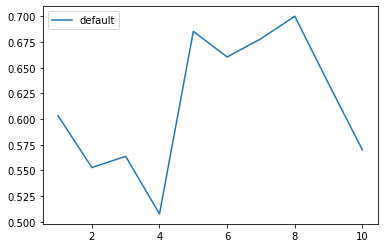

In [2]:
%matplotlib inline

from benchmark.utils.plot import plot

plot('../logs/celeba/default/celeba.json', 'default')